<a href="https://colab.research.google.com/github/liamti5/UZH-Essentials-in-Text-and-Speech-Processing/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pandas
!pip install transformers
!pip install torch
!pip install sentencepiece
!pip install sacremoses

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached sacremoses-0.0.53-py3-none-any.whl


In [1]:
import pandas as pd
import torch
import transformers
import sentencepiece
import numpy as np


/home/liamt/Uni/Master/HS23/EITASP/Essentials-in-Text-and-Speech-Processing/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
with open('../data/reviews_en_translated.csv', 'r') as f:
  df_en_tr = pd.read_csv(f)

with open('../data/reviews_de.csv', 'r') as f:
  df_de = pd.read_csv(f)

df_en_tr = df_en_tr.drop(columns=["translation"])
print(df_en_tr.head())

print(df_de.shape)

                        _id  \
0  5a5e48e1669270001a255a05   
1  5a5e4c87669270001a255a9e   
2  5a5e50f3be6796001a9d7316   
3  5a5e5127be6796001a9d7324   
4  5a5e5161be6796001a9d7337   

                                              review  \
0                              HSG too good for this   
1                             Winkelmann = Ehrenmann   
2  PROs: This module represents for the student t...   
3  Great Prof.! Best one so far. Easy to get good...   
4  The AC part is great but OC is trying to pack ...   

                                        translations  score university  \
0                                   HSG zu gut dafür      1        UZH   
1                             Winkelmann = Ehrenmann      5        UZH   
2                                                NaN      3        UZH   
3  Große Prof.! Beste bis jetzt. Einfach gute Not...      5        UZH   
4  Der AC-Teil ist toll, aber OC versucht, zu vie...      2        UZH   

     course  upvotes  downvotes

In [3]:
df_en_tr = df_en_tr.drop(columns=["review"])
df_en_tr = df_en_tr.rename(columns={"translations": "review"})
print(df_en_tr.head())

                        _id  \
0  5a5e48e1669270001a255a05   
1  5a5e4c87669270001a255a9e   
2  5a5e50f3be6796001a9d7316   
3  5a5e5127be6796001a9d7324   
4  5a5e5161be6796001a9d7337   

                                              review  score university  \
0                                   HSG zu gut dafür      1        UZH   
1                             Winkelmann = Ehrenmann      5        UZH   
2                                                NaN      3        UZH   
3  Große Prof.! Beste bis jetzt. Einfach gute Not...      5        UZH   
4  Der AC-Teil ist toll, aber OC versucht, zu vie...      2        UZH   

     course  upvotes  downvotes           date  \
0  50044544      4.0       41.0  1548419537136   
1  50047387      1.0        0.0  1608566977197   
2  50772388      3.0        0.0  1578223557075   
3  50772226      0.0        1.0  1632840742122   
4  50740660      0.0        1.0  1626375246178   

                                          courseName  \
0          

In [8]:
df_main = pd.concat([df_de, df_en_tr])
df_main.head()
df_main.shape

(9725, 10)

In [7]:
# count amount of empty reviews
print(df_main[df_main['review'].isnull()].shape)


(243, 10)


In [12]:
df_main.to_csv('../data/main.csv', index=False)

In [13]:
# drop empty review rows
df_main = df_main.dropna(subset=['review'])
print(df_main.shape)

(9482, 10)


In [15]:
df_only_relevant = df_main[["review", "score", "university", "course", "upvotes", "downvotes", "date"]]
df_only_relevant.shape

(9482, 7)

In [16]:
df_only_relevant['total_votes'] = df_only_relevant['upvotes'] - df_only_relevant['downvotes']
df_only_relevant['useful'] = (df_only_relevant['upvotes'] - df_only_relevant['downvotes'] > 0).astype(int)
print(df_only_relevant.head())

                                              review  score university  \
0  interessantes aber sehr aufwändiges Fach. Die ...      3        UZH   
1  Warum wird Moodle Verwendet & nicht OLAT? Anso...      4        UZH   
2  langwiilig, Management teil nutzlos, nur uswän...      2        UZH   
3  In diesem Fach zeichnet man Flowcharts und Pro...      3        UZH   
4  weiss nöd warum so viel klaget. de dozent isch...      5        UZH   

     course  upvotes  downvotes           date  total_votes  useful  
0  50314925      0.0        1.0  1562135719091         -1.0       0  
1  50038004      4.0        8.0  1538035078776         -4.0       0  
2  50038000      0.0        1.0  1642090754318         -1.0       0  
3  50330434      0.0        0.0  1515945190594          0.0       0  
4  50030887      1.0        0.0  1655832259676          1.0       1  


/tmp/ipykernel_17353/2098858129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_relevant['total_votes'] = df_only_relevant['upvotes'] - df_only_relevant['downvotes']
/tmp/ipykernel_17353/2098858129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_relevant['useful'] = (df_only_relevant['upvotes'] - df_only_relevant['downvotes'] > 0).astype(int)


In [27]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b5/24/aaccf324ce862bb82277e8814d2aebbb2a2c160d04e95aa2b8c9dc3137a9/matplotlib-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/f1/6b/e4b0f8708f22dd7c321f87eadbb98708975e115ac6582eb46d1f32197ce6/contourpy-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/ac/ed/9a33eca5e2cc35dc1fea0a968509c653db9a99a5979656ae57c6c019d66b/fonttools-4.43.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

5.156415694591728


<Axes: ylabel='Frequency'>

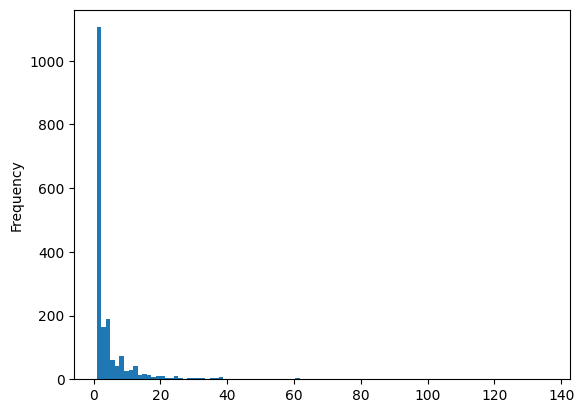

In [32]:
import matplotlib.pyplot as plt
# count of reviews per course
count = df_only_relevant['course'].value_counts()
print(np.mean(count))
# show graph of count
count.plot.hist(bins=100)

<Axes: ylabel='Frequency'>

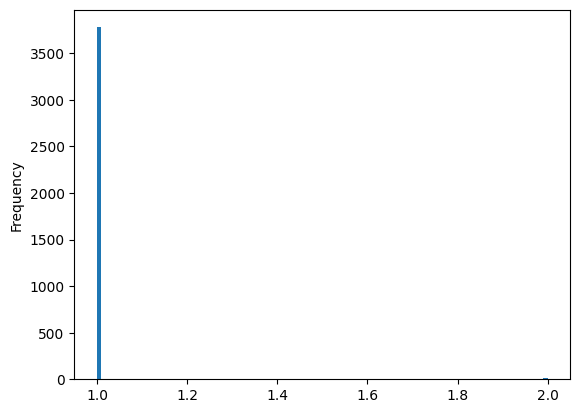

In [46]:
# count positive reviews without 0 for histogram
count = df_only_relevant[df_only_relevant['total_votes'] != 0].value_counts()
count.plot.hist(bins=100)

In [40]:
# remove 0s from upvotes
df_zoom = df_only_relevant[df_only_relevant['upvotes'] != 0]
mean_upvotes = np.mean(df_zoom['upvotes'])
print(mean_upvotes)

4.365236796429457


# Using stuff from lecture instead of just HuggingFace models (even though some of them are also on HuggingFace ^^)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(df['review_text'], convert_to_tensor=True)


/home/liamt/Uni/Master/HS23/EITASP/Essentials-in-Text-and-Speech-Processing/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173245e-02 -4.28515784e-02 -1.56286154e-02  1.40537424e-02
  3.95537950e-02  1.21796258e-01  2.94333603e-02 -3.17524038e-02
  3.54959220e-02 -7.93140531e-02  1.75878778e-02 -4.04369682e-02
  4.97259684e-02  2.54913121e-02 -7.18700141e-02  8.14968273e-02
  1.47072074e-03  4.79627810e-02 -4.50336188e-02 -9.92174670e-02
 -2.81769913e-02  6.45045862e-02  4.44670841e-02 -4.76217493e-02
 -3.52952518e-02  4.38671485e-02 -5.28566614e-02  4.33013309e-04
  1.01921499e-01  1.64072365e-02  3.26996930e-02 -3.45987044e-02
  1.21339653e-02  7.94871002e-02  4.58347425e-03  1.57778990e-02
 -9.68204997e-03  2.87626125e-02 -5.05806692e-02 -1.55794052e-02
 -2.87907068e-02 -9.62282438e-03  3.15556005e-02  2.27349456e-02
  8.71449709e-02 -3.85027714e-02 -8.84718746e-02 -8.75497144e-03
 -2.12343540e-02  2.08924171e-02 -9.02078003e-02 -5.25733083e-02
 -1.05638858e-02  2.88311057e-02 -1.61455423e-02  6.17839489e-03
 -1.23234

# HuggingFace BERT based model

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
df_only_relevant['tokens'] = df_only_relevant['review'].astype(str).apply(tokenizer)
df_only_relevant
df_only_relevant.to_csv('/content/drive/My Drive/Colab/Uni/HS23/EITASP/tokenized.csv', index=False)

df = df_only_relevant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Pad or truncate the tokenized sequences to a fixed length
max_length = 512  # You can adjust this based on the data
X_train_padded = np.array([x[:max_length] + [0]*(max_length - len(x)) for x in X_train])
X_test_padded = np.array([x[:max_length] + [0]*(max_length - len(x)) for x in X_test])

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_padded, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test_padded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep

from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

# Extract 'input_ids' from the 'BatchEncoding' objects and labels
X = df['tokens'].apply(lambda x: x['input_ids'])
y = df['useful']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('google/bert_uncased_L-4_H-256_A-4', num_labels=2)

# Pad or truncate the tokenized sequences to a fixed length
max_length = 512  # You can adjust this based on the data
X_train_padded = [x[:max_length] + [0]*(max_length - len(x)) for x in X_train]
X_test_padded = [x[:max_length] + [0]*(max_length - len(x)) for x in X_test]

# Create DataLoader for training
train_dataset = TensorDataset(torch.tensor(X_train_padded, dtype=torch.long), torch.tensor(list(y_train), dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Create DataLoader for testing
test_dataset = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long), torch.tensor(list(y_test), dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(1):  # Number of epochs
    model.train()
    for i, batch in enumerate(train_loader):
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids)[0]
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for input_ids, labels in test_loader:
        outputs = model(input_ids)[0]
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}")
